In [1]:
import joblib
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from keras.metrics import mean_absolute_error
from tensorflow import keras
from keras import backend as K
import tensorflow as tf
gpus= tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
class RawData():
    def __init__(self, fname, datasize=20000):
        self.df = pd.read_csv(fname)
        self.df = self.df.sort_values(by=['total'], ascending=False).reset_index(drop=True)
        self.df = self.df.iloc[:datasize]
        self.onehotmtx = onehot_coder(self.df, self.get_seqs())

    def get_df(self):
        return self.df

    def get_seqs(self):
        return self.df['utr']

    def get_labels(self):
        return self.df['rl']

    def get_onehotmtxs(self):
        return self.onehotmtx

def onehot_coder(data, seqs):
    inp_len = 50
    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1]}

    onehotmtx = np.empty([len(data), inp_len, 4])  ## initialize
    for i in range(len(data)):
        seq = seqs.iloc[i]
        seq = seq.lower()
        for n, x in enumerate(seq):
            onehotmtx[i][n] = np.array(nuc_d[x])
    return onehotmtx

In [3]:

def r2(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value ** 2

def weighted_squared_error(y_true, y_pred):

    ltavg = y_true > 0

    mse = K.square(y_pred - y_true)
    weighted_mse = (1 + y_true) * K.square(y_pred - y_true)

    return K.mean(tf.where(ltavg, weighted_mse, mse))


losses = {
    "rl_output": weighted_squared_error,
    "decoded_output": 'categorical_crossentropy',
}

def check_datafreq(df):
    ## check data distribution
    print("### ===  MRL value distribution in testdata  === ###  datasize = ", len(df))
    print(df['rl_cate'].value_counts().sort_index())
    return 0



In [4]:

def metrics_subsets(model, scaler, df, dis_label, ae_flag=1):
    ## calculate r-squared value for each rl Categories
    r2_list = []
    mae_list = []
    all_y_true = []
    all_y_pred = []
    for cate in dis_label[:]:
        sub_df = df.loc[df['rl_cate'] == cate]  ## 整行，34列
        test_labels = sub_df['rl'].to_numpy().reshape(1, -1)
        test_mtx = onehot_coder(sub_df, sub_df['utr'])
        if (ae_flag==1):
            pred_labels = model.predict(test_mtx)[1].reshape(1,-1)
        else:
            pred_labels = model.predict(test_mtx).reshape(1, -1)
        pred_labels = scaler.inverse_transform(pred_labels)
        y_ture = test_labels[0].astype(np.float32)
        y_pred = pred_labels[0].astype(np.float32)
        r = r2(y_ture, y_pred)
        r2_list.append(r)
        mae = mean_absolute_error(y_ture, y_pred)
        mae_list.append(mae)

        all_y_true = np.concatenate((all_y_true,y_ture),axis=0)
        all_y_pred = np.concatenate((all_y_pred,y_pred),axis=0)

    return r2_list, mae_list

In [5]:

## load test dataset
test_df = RawData("../data/GSM3130440_egfp_m1pseudo_2.csv", 20000).get_df()

In [6]:
## divide test data into sub datasets
rl_bin = [-1, 2, 3, 4, 5, 6, 6.5, 7, 8]  ## no data with rl more than 8
dis_label = ['[0, 2]', '(2, 3]', '(3, 4]', '(4, 5]', '(5, 6] ','(6, 6.5]', '(6.5, 7]', '(7, 8]']

## add categories
test_df.insert(32, 'rl_cate', pd.cut(test_df['rl'], bins=rl_bin, labels=dis_label))
check_datafreq(test_df)

### ===  MRL value distribution in testdata  === ###  datasize =  20000
[0, 2]       197
(2, 3]      1171
(3, 4]      1592
(4, 5]      2090
(5, 6]      4366
(6, 6.5]    4859
(6.5, 7]    4313
(7, 8]      1412
Name: rl_cate, dtype: int64


0

In [7]:

## load models
ae_model = keras.models.load_model(
    '../models/Smart5UTR/Smart5UTR_egfp_m1pseudo2_Model.h5',
    compile=False)

ae_model.compile(loss=losses,
                    metrics={'rl_output': 'mse', 'decoded_output': 'accuracy'})
scaler =joblib.load("../models/egfp_m1pseudo2.scaler")

opt_model = keras.models.load_model('../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_model_200k.h5')


In [8]:
ae_r2_list, ae_mae_list = metrics_subsets(ae_model , scaler, test_df, dis_label, ae_flag=1)
opt_r2_list, opt_mae_list = metrics_subsets(opt_model, scaler, test_df, dis_label, ae_flag=0)

C:\Users\FloretLi\AppData\Local\Temp\ipykernel_16644\2826633073.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0, 6000, 1000), fontname="Arial",fontweight="bold")
C:\Users\FloretLi\AppData\Local\Temp\ipykernel_16644\2826633073.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(0, 2.25, 0.25), fontname="Arial",fontweight="bold")


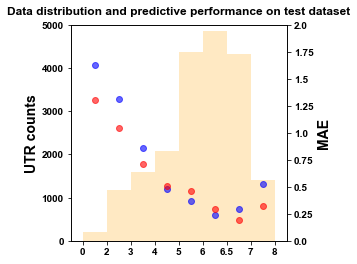

In [9]:
### plot the results
## plot data frequency in each subset
fig = plt.figure()
fig.set_size_inches((5, 5))

# ax1 = plot_freq(test_df, dis_label, fig)

fraq_list = test_df['rl_cate'].value_counts().loc[dis_label].to_list()

# ax1 = fig.add_subplot(111)
ax1=fig.add_axes([0.2,0.2,0.6,0.6])
ax1.bar(range(len(fraq_list)), fraq_list, width=1, align='center', alpha=0.8, color = "moccasin" )## 'lightgreen')
ax1.set_ylabel('UTR counts', fontname="Arial",fontweight="bold",fontsize=14, labelpad=3)
ax1.set_xlim([-1, len(fraq_list)])
ax1.set_xticks([i - 0.5 for i in range(len(fraq_list)+1)])
ax1.set_ylim([0,5000])
ax1.set_yticklabels(np.arange(0, 6000, 1000), fontname="Arial",fontweight="bold")

ax1.set_xticklabels(["0", "2", "3", "4", "5", "6", "6.5", "7", "8"], fontname="Arial",fontweight="bold")

ax1.set_title("Data distribution and predictive performance on test dataset",fontname="Arial",fontweight="bold",fontsize=12, pad=10)


ax2 = ax1.twinx()
ax2.scatter(range(len(opt_mae_list)), opt_mae_list, color="b", marker='o',alpha=0.6, label="Optimus5-Prime-MAE")
ax2.scatter(range(len(ae_mae_list)), ae_mae_list, color="r", marker='o',alpha=0.6, label="smart5UTR-MAE")
ax2.set_ylabel('MAE', fontname="Arial",fontweight="bold",fontsize=14, labelpad=3)
ax2.set_ylim([0, 2])
ax2.set_yticklabels(np.arange(0, 2.25, 0.25), fontname="Arial",fontweight="bold")
ax2.set_xlabel("MRL value", fontname="Arial",fontweight="bold",fontsize=14, labelpad=3)


# ## add text
# for a, b in zip(range(len(ae_r2_list)),  ae_r2_list):
#     plt.text(a, b + 0.05, '%.4f' % b, ha='center', va='bottom', fontsize=7)

# for a, b in zip(range(len(ae_mae_list)),  ae_mae_list):
#     plt.text(a, b + 0.05, '%.4f' % b, ha='center', va='bottom', fontsize=7)

# plt.legend(loc='upper left')
plt.show()

In [10]:
fig.savefig('../figs/fig2-performance-each-bin.png', dpi=300)